# Hashing with chaining in Python

Notes from MIT Lecture [8. Hashing with Chaining](https://www.youtube.com/watch?v=0M_kIqhwbFo)

## Contents

- Dictionaries & Python
- Motivation
- Pre-hashing
- Hashing
- Chaining
- Simple uniform hashing
- "Good" hash functions

## Theory

### Purpose

Dictionary is an **abstract data type** / ADT (the model / behaviour of a data type from the POV of the user, vs. _data structure_, which is the concrete implementation from the POV of the implementer).

> For example, integers are an ADT, defined as the values ..., −2, −1, 0, 1, 2, ..., and by the operations of addition, subtraction, multiplication, and division, together with greater than, less than, etc., which behave according to familiar mathematics (with care for integer division), independently of how the integers are represented by the computer.

(from [Wikipedia](https://en.wikipedia.org/wiki/Abstract_data_type))

Purpose of a dict is to store a set of items. Each item has a **key**. You can do the following operations:
- insert(item) -> overwrite any existing key (default Python behaviour)
- delete(item)
- search(key) -> return item with given key (_exact search_), or report that the key does not exist (_KeyError_)

Possible implementation of a dict could be AVL tree, that searches in _O(log(n))_ time. But, we can search even faster than log(n) time! Dicts search down to **_constant time_, O(1)**!

And because dictionary search is so fast, we can afford to do many lookups (trials, perturbations, etc).

Dicts and hashing are used everywhere! For example:
- Dicts are the basis of many databases
- Compilers and interpreters: variable names are stored in a dict
- In routing tables, because routers need to be very fast
- Efficient substring search uses hashing
- String comparison uses hashing
- Hashing is used for file/directory sync! e.g. rsync, git -> to tell whether a file has changed
- Also in cryptography, for checksums (cryptographic hash functions)

### Python dicts

In [1]:
# Notice that the Python notation for indexing a dict is
# identical to the notation for indexing an array!

d = dict()
d['a'] = 1    # insert
d['b'] = 2
d['a']        # search
del d['a']    # delete
d.items()     # an item is a (key, value) pair

dict_items([('b', 2)])

### Simple approach

Very simple idea: use a direct-access table. Store the items in an array, indexed by the key.

Disadvantages:
1. I can only use non-negative integers as keys
2. Could use a lot of memory, e.g. if keys are 64-bit ints, then I need 2^64 slots!

### Solution to problem 1: Pre-hashing

What Python calls `hash` is technically _pre-hashing_: mapping keys to non-negative integers.

For objects, `hash()` is just the id of the object, i.e. its memory location. This pre-hash function can be changed by overriding the `__hash__()` special method in the class. But, you have to make sure that the value returned is always the same for a given key.

Ideally, `hash(x) == hash(y) <=> x == y`. But in reality:

In [2]:
print(hash(1))    # pre-hash of an integer is the integer itself

1


In [3]:
assert hash(1) == hash(True)  # hash collision!

In [1]:
# but for strings, Python is smarter:
assert hash('a') != hash(hash('a'))  # no collision

### Solution to problem 2: Hashing

A _hash function_ `h(k,m)` is used to reduce _keyspace_ (the huge total set of possible keys) to a smaller set of size `m`, called the _hash table_:

`keyspace  --h(k,m)-->  T(1..m)`

And we want to try to keep the number of slots in the hash table as close as possible to the number of items (i.e. growing not more than linearly): `m = O(n)`

### Chaining

Problem of hashing: collisions are guaranteed to happen, i.e. `hash(x) == hash(y) but x != y`.

2 possible solutions to collisions:
- Chaining
- Open addressing

Chaining: if keys have the same hash, store them in the same position as a list (e.g. a linked list).

**Worst case** for any hashing scheme is _O(n)_, if all the keys go in the same slot and are thus stored in an _n_-length linked list.

But in practice, hashing works really well! The reason is **randomization** and probabilistic assumptions.

### Simple uniform hashing assumption

This consists of 2 **probabilistic assumptions**:
1. **Uniformity**: each key is equally likely to be hashed to any slot of the table (uniform random choice).
2. **Independence**: each key's hash is independent of other keys' hash.

And if these 2 assumptions hold true, then it can be proved that dictionaries work in _constant time_ O(1).

#### Load factor

Under the simple uniform hashing assumption, the **load factor** of a table (`n/m = α` for `n` keys and `m` slots) is equal to the **expected length of the chain**.

So we want to keep the load factor close to 1, to achieve running constant time O(1+α) (+1 because there is always one operation to compute the hash function).

### Example hash functions

1. **Division method** (common in practice, but not good/provable theoretically): `h(k,m) = k mod m`. Especially bad if `m` has common factors with `k` (e.g. is even). Solution: good to use a table size `m` that is prime, and is not close to a power of 2 or of 10. A bit hacky.
2. **Multiplication method**: `h(k,m) = [(a*k) mod 2^w] >> (w-r)` => if we are on a `w`-bit machine (word size), `a` is a random integer. If I multiply in binary, I am adding up 'shifted' versions of `k` (wherever there is a 1 bit in `a`). I then take the centermost (most 'randomized') part of the multiplication result. `r` is chosen such that `m = 2^r`.
3. **Universal hashing** (theoretically good): `h(k) = [(ak+b) mod p] mod m`. On the outside, `mod m` is just to make the output between `(0..m-1`). `a` and `b` are random numbers between `(0..p-1`), `p` is a very large prime number (computed once when creating the table). In this scheme, the **worst case** probability of collision (over the choice of `a` and `b`) is `1/m`! -> and this expectation is exactly what we need to satisfy the simple uniform hashing assumption, under which dictionaries run in constant time!

## Implementation

Here is my implementation of a hash map in Python, with custom parameters:

In [53]:
class HackableHashMap(object):

    def __init__(self, prehash_func=None, hash_func=None,
                 init_size=8, load_factor=0.75, growth_rate=2):
        self.prehash_func = prehash_func or hash  # python built-in
        self.hash_func = hash_func or self.division_hash
        self.init_size = init_size
        self.load_factor = load_factor
        self.growth_rate = growth_rate
        self.table = [[] for _ in range(init_size)]
        self.num_items = 0
        self.count_resize = 0
        self.count_collisions = 0
        self.nonuniformity = self._calc_nonuniformity()

    @staticmethod
    def division_hash(k, m):
        """Default hash function"""
        return k % m

    def _calc_idx_for_key(self, key, table_size=None):
        if not table_size:
            table_size = len(self.table)
        # TODO: check if key is hashable
        return self.hash_func(self.prehash_func(key), table_size)

    def _needs_resize(self):
        current_load = self.num_items / len(self.table)
        print(f"current load = {current_load:.2f}")
        return current_load > self.load_factor

    def _resize_table(self):
        # TODO: shrink table size after deletion of items
        new_size = max(2, int(self.num_items * self.growth_rate))
        new_table = [[] for _ in range(new_size)]
        for key, val in self.gen_items():
            idx = self._calc_idx_for_key(key, table_size=new_size)
            new_table[idx].append((key, val))
        print(f"resizing table from {len(self.table)} to {new_size} slots")
        self.table = new_table
        self.count_resize += 1
        return
    
    def _calc_nonuniformity(self):
        """Non-uniformity is the standard deviation of chain length across slots"""
#         chain_sizes = [len(slot) for slot in self.table]
#         m = sum(chain_sizes) / len(chain_sizes)
#         stdev = sum((x - m)**2 for x in chain_sizes) / (len(chain_sizes) - 1)
#         return stdev
        return len([slot for slot in self.table if len(slot) < 1]) / len(self.table)

    def set_item(self, key, val):
        # Check if we need to resize table (based on load factor)
        if self._needs_resize():
            self._resize_table()

        idx = self._calc_idx_for_key(key)
        for j, item in enumerate(self.table[idx]):
            if item[0] == key:  # key already exists
                print(f"key '{key}' already exists - overwriting value")
                self.table[idx][j] = (key, val)
                return
            else:  # keep track of collisions (multiple items in same slot)
                self.count_collisions += 1

        print(f"new key '{key}' - writing value at idx={idx}")
        self.table[idx].append((key, val))
        self.num_items += 1
        return

    def get_item(self, key):
        idx = self._calc_idx_for_key(key)
        for j, item in enumerate(self.table[idx]):
            if item[0] == key:
                return item[1]
        raise KeyError

    def del_item(self, key):
        idx = self._calc_idx_for_key(key)
        for j, item in enumerate(self.table[idx]):
            if item[0] == key:
                print(f"deleting item {item} at idx={idx}")
                self.table[idx].pop(j)
                self.num_items -= 1
                if len(self.table[idx]) > 0:  # slot is non-empty
                    self.count_collisions -= 1
                return
        raise KeyError

    def gen_items(self):
        """Generator of (key, value) tuples, ordered by table index"""
        for slot in self.table:
            for item in slot:
                yield item

    def __str__(self):
        out = ''
        for idx, item in enumerate(self.table):
            out += f'[{idx}]   {item}\n'
        return out

In [54]:
m = HackableHashMap()
m.set_item('a', 1)
m.set_item('b', 2)
m.set_item('b', 3)
m.set_item('c', 4)
print('\nHash table\n==========\n')
print(m)

current load = 0.00
new key 'a' - writing value at idx=0
current load = 0.12
new key 'b' - writing value at idx=2
current load = 0.25
key 'b' already exists - overwriting value
current load = 0.25
new key 'c' - writing value at idx=0

Hash table

[0]   [('a', 1), ('c', 4)]
[1]   []
[2]   [('b', 3)]
[3]   []
[4]   []
[5]   []
[6]   []
[7]   []



### Comparing hash functions

Now let's add some other fancier hash functions:

In [55]:
# Precalculate list of large primes (to be used by universal_hash())
primes = [x for x in range(1000, 10000) if not [t for t in range(2, x) if not x % t]]


def multiplication_hash() -> callable:
    from random import randint
    from sys import maxsize
    from math import log2

    a = randint(0, maxsize-1)
    w = 64 if maxsize > 2**32 else 32  # word size of machine

    def calc_hash(k: int, m: int) -> int:
        r = int(log2(m))
        return ((a*k) % 2**w) >> (w-r)

    return calc_hash


def universal_hash() -> callable:
    from random import randint, choice

    p = choice(primes)
    a = randint(0, p-1)
    b = randint(0, p-1)

    def calc_hash(k: int, m: int) -> int:
        return ((a*k + b) % p) % m

    return calc_hash

Let's compare the performance of several hash functions based on the following metrics:
- Number of collisions
- Number of resizings needed
- Non-uniformity metric (proportion of empty slots over total number of slots)

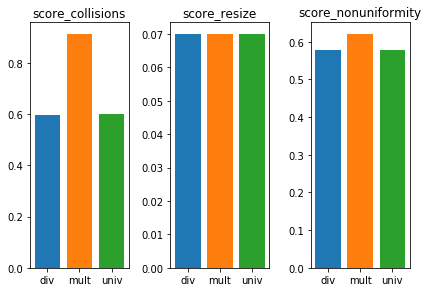

In [58]:
import matplotlib.pyplot as plt
from matplotlib import style
from IPython.utils import io
from random import sample
%matplotlib inline

# Params
n_maps = 1000       # number of maps to generate for each hashfunc
table_size = 100    # number of items per map
hash_funcs = [
    HackableHashMap.division_hash,
    multiplication_hash(),
    universal_hash()
]
hash_func_names = ['div', 'mult', 'univ']

# Plotting settings
fig, axes = plt.subplots(nrows=1, ncols=3)
plt.tight_layout()
axes[0].set_title('score_collisions')
axes[1].set_title('score_resize')
axes[2].set_title('score_nonuniformity')

# Calculation
for s, h in enumerate(hash_funcs):
    
    score_collisions = []
    score_resize = []
    score_nonuniformity = []

    for _ in range(n_maps):
        keys = sample(range(table_size, 2**32), table_size)
        with io.capture_output() as captured:  # disable print output
            m = HackableHashMap(hash_func=h);
            for i in range(table_size):
                # for this experiment, only add items, no deletions
                m.set_item(keys[i], 0);
        score_collisions.append(m.count_collisions / table_size)
        score_resize.append(m.count_resize / table_size)
        score_nonuniformity.append(m._calc_nonuniformity())
        
    score_collisions_mean = sum(score_collisions) / len(score_collisions)
    score_resize_mean = sum(score_resize) / len(score_resize)
    score_nonuniformity_mean = sum(score_nonuniformity) / len(score_nonuniformity)
    
    axes[0].bar(s, score_collisions_mean)
    axes[1].bar(s, score_resize_mean)
    axes[2].bar(s, score_nonuniformity_mean)

for i in range(3):
    axes[i].set_xticks([0,1,2])
    axes[i].set_xticklabels(hash_func_names)

In [59]:
# Print example map

print(m)

[0]   [(564350233, 0), (520396759, 0)]
[1]   [(891253287, 0), (3671895815, 0), (1761563017, 0), (3902202784, 0)]
[2]   []
[3]   []
[4]   [(2451453395, 0), (270800456, 0)]
[5]   [(2007340289, 0)]
[6]   [(3670848650, 0), (3747799268, 0)]
[7]   []
[8]   [(1913520691, 0)]
[9]   []
[10]   [(3896589553, 0)]
[11]   []
[12]   [(3051543398, 0)]
[13]   [(2393317400, 0)]
[14]   []
[15]   [(2491551663, 0)]
[16]   [(4139451554, 0), (3096447415, 0)]
[17]   []
[18]   []
[19]   []
[20]   [(2746057841, 0)]
[21]   []
[22]   [(1734530714, 0)]
[23]   []
[24]   []
[25]   []
[26]   [(4281068696, 0), (3696294635, 0)]
[27]   []
[28]   [(3655162979, 0), (4281342949, 0)]
[29]   []
[30]   [(60180363, 0)]
[31]   []
[32]   []
[33]   [(3317651737, 0)]
[34]   []
[35]   []
[36]   []
[37]   []
[38]   [(3551092684, 0)]
[39]   [(2165111976, 0)]
[40]   [(2567518961, 0), (515400782, 0)]
[41]   [(2051196134, 0)]
[42]   []
[43]   [(4123282870, 0)]
[44]   []
[45]   [(3630483861, 0)]
[46]   [(3093765876, 0), (2628382414, 0)]
